In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
pip install transformers

In [7]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, BertForSequenceClassification, AutoModelForSequenceClassification, AdamW

In [8]:
data = pd.read_csv('/content/drive/MyDrive/Academic/Soft Computing/bangla_comments_tokenized.csv')
data.head()

label                                               text  \
0  Political  ছালা পাকিস্তানী বাশ দিয়া দাও ভর দিয়া হাটবো অভা...   
1  religious           ফ্যামিলিটা নাস্তিক থক আশা কর যায় না ফাউল   
2     sexual  তুই মাগি মাফ তুই আখিরাত বিশ্বাস করস না তুই বাপ...   
3  religious  সাফা কবির কঠিনফ্ ছিল তো চরমঘৃনা করি তুই নাস্তি...   
4  not bully                                       সুপ সুপ হিরো   

                                          clean_text  \
0  ছালা পাকিস্তানীদের বাশ দিয়া দাও ভর দিয়া হাটবো ...   
1        ফ্যামিলিটাই নাস্তিক থকে আশা করা যায় না ফাউল   
2  তুই মাগি মাফ তুই আখিরাত বিশ্বাস করস না তুই বাপ...   
3  সাফা কবির কঠিনফ্ ছিলাম তো চরমঘৃনা করি তুই নাস্...   
4                                   সুপার সুপার হিরো   

                                tokenized_clean_text  \
0  ['ছালা', 'পাকিস্তানীদের', 'বাশ', 'দিয়া', 'দাও'...   
1  ['ফ্যামিলিটাই', 'নাস্তিক', 'থকে', 'আশা', 'করা'...   
2  ['তুই', 'মাগি', 'মাফ', 'তুই', 'আখিরাত', 'বিশ্ব...   
3  ['সাফা', 'কবির', 'কঠিনফ্', 'ছিলাম', 'তো', 'চরম...   
4                         ['সুপার', 'সুপার', 'হিরো']   

                                 tokenized_stem_text  token_length  
0  ['ছালা', 'পাকিস্তানী', 'বাশ', 'দিয়া', 'দাও', '...            13  
1  ['ফ্যামিলিটা', 'নাস্তিক', 'থক', 'আশা', 'কর', '...             8  
2  ['তুই', 'মাগি', 'মাফ', 'তুই', 'আখিরাত', 'বিশ্ব...            19  
3  ['সাফা', 'কবির', 'কঠিনফ্', 'ছিল', 'তো', 'চরমঘৃ...            14  
4                             ['সুপ', 'সুপ', 'হিরো']             3

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42036 entries, 0 to 42035
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   label                 42036 non-null  object
 1   text                  42035 non-null  object
 2   clean_text            42035 non-null  object
 3   tokenized_clean_text  42036 non-null  object
 4   tokenized_stem_text   42036 non-null  object
 5   token_length          42036 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 1.9+ MB


In [10]:
print(data['label'].value_counts())

Political    11000
sexual       11000
not bully    11000
religious     9036
Name: label, dtype: int64


In [11]:
text = data['text']
label = data['label']

print('Input features of text shape:', text.shape)
print('Target variable of label shape:', label.shape)

Input features of text shape: (42036,)
Target variable of label shape: (42036,)


In [12]:
max_length = max(len(i) for i in data['tokenized_clean_text'])
print("Max sequence length:", max_length)

Max sequence length: 1873


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


tokenizer_name = 'bert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)


class SentimentDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

        self.label_map = {"Political": 0, "religious": 1, "sexual": 2, "not bully": 3}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = str(self.data['tokenized_clean_text'][idx])
        label_str = self.data['label'][idx]
        label = self.label_map[label_str]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens = True,
            padding = 'max_length',
            truncation = True,
            max_length = 128,
            return_tensors = 'pt'
        )

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return {
            'input_ids': input_ids.to(device),
            'attention_mask': attention_mask.to(device),
            'label': torch.tensor(label).to(device)
        }

In [14]:
def plot_loss_accuracy(train_loss_list, train_acc_list, val_loss_list, val_acc_list):
    plt.figure(figsize=(9, 3))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_list, label='Training Accuracy')
    plt.plot(val_acc_list, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Store training and validation loss and accuracy for plotting
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []


In [15]:
dataset = SentimentDataset(data, tokenizer)

train_data, temp_data = train_test_split(dataset, test_size = 0.2)
val_data, test_data = train_test_split(temp_data, test_size = 0.5)


batch_size = 100
num_iters = 2102
train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_data, batch_size = batch_size, shuffle = False)
test_dataloader = DataLoader(test_data, batch_size = batch_size, shuffle = False)


num_labels = 4
model_name = 'bert-base-multilingual-cased'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.to(device)


optimizer = AdamW(model.parameters(), lr = 2e-5)
loss_fn = torch.nn.CrossEntropyLoss()


num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)

print_every = 100

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for i, batch in enumerate(train_dataloader):
        inputs = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        optimizer.zero_grad()

        outputs = model(inputs, attention_mask=attention_mask)
        logits = outputs.logits

        loss = loss_fn(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted_labels = torch.max(logits, dim = 1)
        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.size(0)

        if (i + 1) % print_every == 0 or (i + 1) == len(train_dataloader):
            train_loss = total_loss / (i + 1)
            train_accuracy = (correct_predictions / total_predictions) * 100

            print(f"Iteration {i + 1}/{len(train_dataloader)}, Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

    train_loss = total_loss / len(train_dataloader)
    train_accuracy = (correct_predictions / total_predictions) * 100
    train_loss_list.append(train_loss)
    train_acc_list.append(train_accuracy)


    model.eval()
    val_loss = 0
    val_accuracy = 0

    with torch.no_grad():
        for val_batch in val_dataloader:
            val_inputs = val_batch['input_ids']
            val_attention_mask = val_batch['attention_mask']
            val_labels = val_batch['label']

            val_outputs = model(val_inputs, attention_mask=val_attention_mask)
            val_logits = val_outputs.logits

            val_loss += loss_fn(val_logits, val_labels).item()

            _, predicted_labels = torch.max(val_logits, dim = 1)
            val_accuracy += (predicted_labels == val_labels).sum().item()

    avg_val_loss = val_loss / len(val_dataloader)
    accuracy = (val_accuracy / len(val_data)) * 100

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%")

    avg_val_loss = val_loss / len(val_dataloader)
    accuracy = (val_accuracy / len(val_data)) * 100
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(accuracy)


model.eval()
test_loss = 0
test_accuracy = 0

with torch.no_grad():
    for test_batch in test_dataloader:
        test_inputs = test_batch['input_ids']
        test_attention_mask = test_batch['attention_mask']
        test_labels = test_batch['label']

        test_outputs = model(test_inputs, attention_mask=test_attention_mask)
        test_logits = test_outputs.logits

        test_loss += loss_fn(test_logits, test_labels).item()

        _, predicted_labels = torch.max(test_logits, dim = 1)
        test_accuracy += (predicted_labels == test_labels).sum().item()

avg_test_loss = test_loss / len(test_dataloader)
accuracy = (test_accuracy / len(test_data)) * 100

print(f"Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Iteration 100/337, Train Loss: 0.9810, Accuracy: 58.22%
Iteration 200/337, Train Loss: 0.8003, Accuracy: 67.52%
Iteration 300/337, Train Loss: 0.7249, Accuracy: 71.23%
Iteration 337/337, Train Loss: 0.7047, Accuracy: 72.20%
Epoch 1/6, Train Loss: 0.7047, Accuracy: 72.20%
Epoch 1/6, Validation Loss: 0.5207, Accuracy: 81.26%
Iteration 100/337, Train Loss: 0.4743, Accuracy: 82.57%
Iteration 200/337, Train Loss: 0.4722, Accuracy: 82.59%
Iteration 300/337, Train Loss: 0.4671, Accuracy: 82.88%
Iteration 337/337, Train Loss: 0.4657, Accuracy: 82.90%
Epoch 2/6, Train Loss: 0.4657, Accuracy: 82.90%
Epoch 2/6, Validation Loss: 0.4564, Accuracy: 84.04%
Iteration 100/337, Train Loss: 0.3896, Accuracy: 86.14%
Iteration 200/337, Train Loss: 0.3904, Accuracy: 86.02%
Iteration 300/337, Train Loss: 0.3915, Accuracy: 85.96%
Iteration 337/337, Train Loss: 0.3902, Accuracy: 85.98%
Epoch 3/6, Train Loss: 0.3902, Accuracy: 85.98%
Epoch 3/6, Validation Loss: 0.4490, Accuracy: 84.49%
Iteration 100/337, Train 

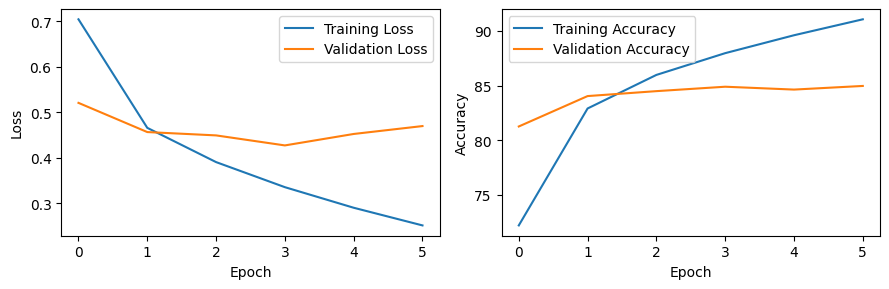

In [16]:
plot_loss_accuracy(train_loss_list, train_acc_list, val_loss_list, val_acc_list)

In [17]:
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for test_batch in test_dataloader:
        test_inputs = test_batch['input_ids']
        test_attention_mask = test_batch['attention_mask']
        test_labels = test_batch['label']

        test_outputs = model(test_inputs, attention_mask=test_attention_mask)
        test_logits = test_outputs.logits

        test_loss += loss_fn(test_logits, test_labels).item()

        _, predicted_labels = torch.max(test_logits, dim=1)
        all_predictions.extend(predicted_labels.cpu().tolist())
        all_labels.extend(test_labels.cpu().tolist())

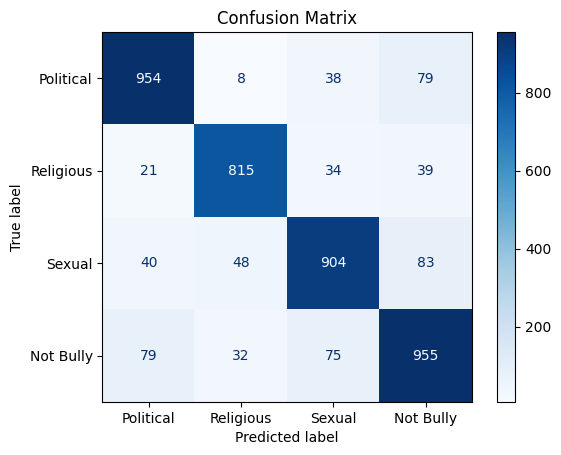

In [18]:
conf_matrix = confusion_matrix(all_labels, all_predictions)
class_names = ["Political", "Religious", "Sexual", "Not Bully"]
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [19]:
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

   Political       0.87      0.88      0.88      1079
   Religious       0.90      0.90      0.90       909
      Sexual       0.86      0.84      0.85      1075
   Not Bully       0.83      0.84      0.83      1141

    accuracy                           0.86      4204
   macro avg       0.87      0.86      0.86      4204
weighted avg       0.86      0.86      0.86      4204



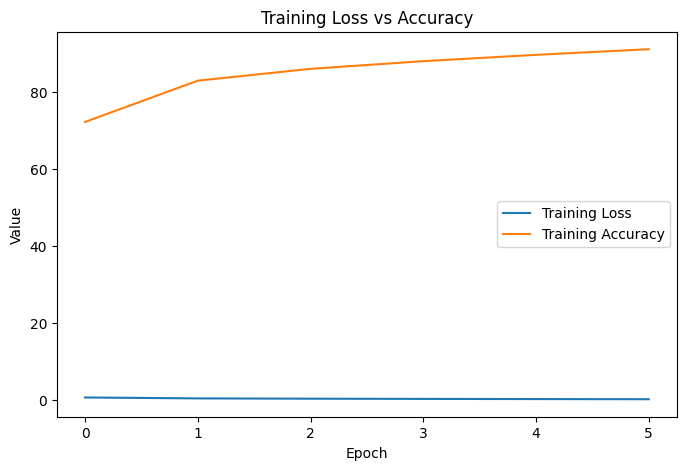

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(train_acc_list, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Training Loss vs Accuracy')
plt.show()

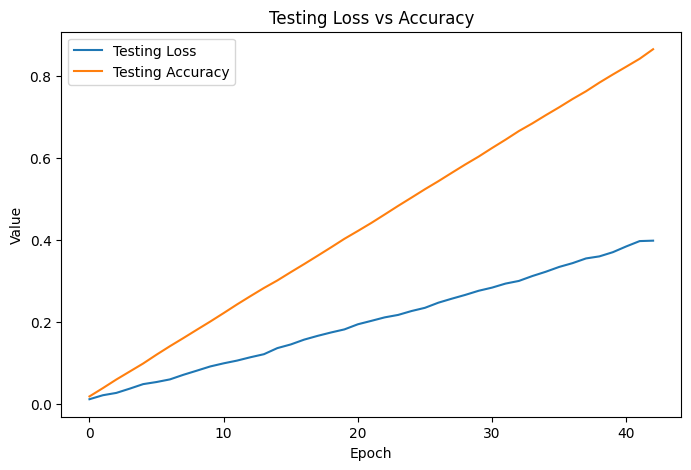

In [21]:
model.eval()
test_loss = 0
test_accuracy = 0
test_loss_list = []
test_acc_list = []

with torch.no_grad():
    for test_batch in test_dataloader:
        test_inputs = test_batch['input_ids']
        test_attention_mask = test_batch['attention_mask']
        test_labels = test_batch['label']

        test_outputs = model(test_inputs, attention_mask=test_attention_mask)
        test_logits = test_outputs.logits

        loss = loss_fn(test_logits, test_labels)
        test_loss += loss.item()

        _, predicted_labels = torch.max(test_logits, dim=1)
        correct_predictions = (predicted_labels == test_labels).sum().item()
        total_predictions = test_labels.size(0)
        test_accuracy += correct_predictions / total_predictions

        test_loss_list.append(test_loss / len(test_dataloader))
        test_acc_list.append(test_accuracy / len(test_dataloader))

# Plot testing loss vs accuracy graph
plt.figure(figsize=(8, 5))
plt.plot(test_loss_list, label='Testing Loss')
plt.plot(test_acc_list, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Testing Loss vs Accuracy')
plt.show()


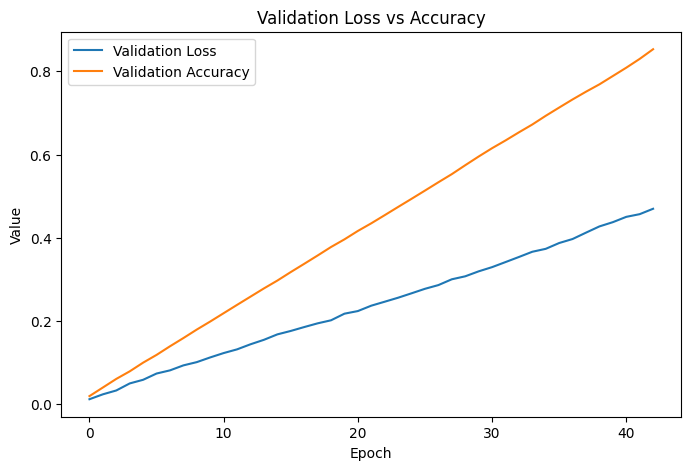

In [22]:
model.eval()
val_loss = 0
val_accuracy = 0
val_loss_list = []
val_acc_list = []

with torch.no_grad():
    for val_batch in val_dataloader:
        val_inputs = val_batch['input_ids']
        val_attention_mask = val_batch['attention_mask']
        val_labels = val_batch['label']

        val_outputs = model(val_inputs, attention_mask=val_attention_mask)
        val_logits = val_outputs.logits

        loss = loss_fn(val_logits, val_labels)
        val_loss += loss.item()

        _, predicted_labels = torch.max(val_logits, dim=1)
        correct_predictions = (predicted_labels == val_labels).sum().item()
        total_predictions = val_labels.size(0)
        val_accuracy += correct_predictions / total_predictions

        val_loss_list.append(val_loss / len(val_dataloader))
        val_acc_list.append(val_accuracy / len(val_dataloader))

# Plot validation loss vs accuracy graph
plt.figure(figsize=(8, 5))
plt.plot(val_loss_list, label='Validation Loss')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Validation Loss vs Accuracy')
plt.show()


In [23]:
#model.save_pretrained("/content/drive/MyDrive/Academic/Soft Computing/model4b")